In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls "/content/drive/My Drive/dataset"

Dataset1.csv  Friday-WorkingHours-Afternoon-DDos_scaledDOWN.csv
Dataset2.csv  network_flow_features.csv


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

dataset_path = "/content/drive/My Drive/dataset/Dataset1.csv"
df = pd.read_csv(dataset_path)
df.columns = df.columns.str.strip()
df.columns = df.columns.astype(str)

df['Label'] = df['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)

X = df.drop(columns=['Label'])
y = df['Label']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_scaled, y)
rf_importances = rf_model.feature_importances_

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_scaled, y)
xgb_importances = xgb_model.feature_importances_

rf_top_features = np.argsort(rf_importances)[-20:]
xgb_top_features = np.argsort(xgb_importances)[-20:]
selected_features = list(set(X.columns[rf_top_features]) & set(X.columns[xgb_top_features]))

X_selected = df[selected_features]

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_selected, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

base_learners = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('xgb', XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=6, subsample=0.8, colsample_bytree=0.8,
                          scale_pos_weight=len(y_train) / sum(y_train), random_state=42)),
]

stacking_model = StackingClassifier(estimators=base_learners, final_estimator=LogisticRegression())

stacking_model.fit(X_train, y_train)
y_pred = stacking_model.predict(X_test)
#print(y_pred)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:41:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   Actual Label Predicted Label
0     Malicious       Malicious
1        Normal          Normal
2        Normal          Normal
3     Malicious       Malicious
4        Normal          Normal
5        Normal          Normal
6        Normal          Normal
7        Normal          Normal
8        Normal          Normal
9     Malicious       Malicious
10       Normal          Normal
11       Normal          Normal
12       Normal          Normal
13       Normal          Normal
14       Normal       Malicious
15    Malicious       Malicious
16       Normal          Normal
17       Normal          Normal
18       Normal          Normal
19       Normal          Normal
20       Normal          Normal
21       Normal          Normal
22    Malicious       Malicious
23       Normal          Normal
24       Normal          Normal
25       Normal          Normal
26       Normal          Normal
27       Normal          Normal
28       Normal          Normal
29    Malicious       Malicious
30      

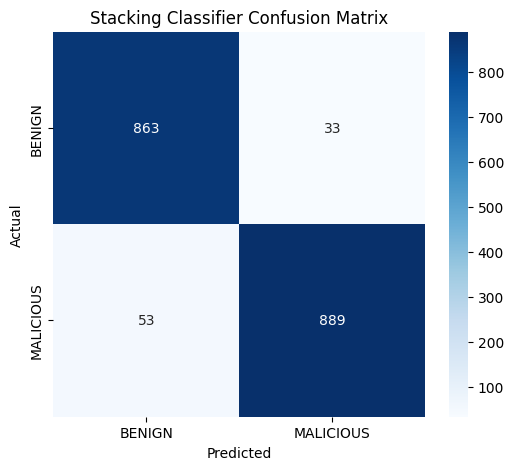

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

dataset_path = "/content/drive/My Drive/dataset/Dataset2.csv"
data = pd.read_csv(dataset_path)

data.columns = df.columns.astype(str)
data.columns = data.columns.str.strip()

if 'Label' in data.columns:
    actual_labels = data['Label'].apply(lambda x: "Normal" if x == "BENIGN" else "Malicious")
else:
    raise ValueError("Label column not found in dataset!")

Z = data.drop(columns=['Label'], errors='ignore')

if hasattr(stacking_model, "feature_names_in_"):
    missing_cols = set(stacking_model.feature_names_in_) - set(Z.columns)
    extra_cols = set(Z.columns) - set(stacking_model.feature_names_in_)

    for col in missing_cols:
        Z[col] = 0

    Z = Z[stacking_model.feature_names_in_]

pred = stacking_model.predict(Z)

label_mapping = {0: "Normal", 1: "Malicious"}
pred_labels = np.array([label_mapping[p] for p in pred])

comparison_df = pd.DataFrame({
    "Actual Label": actual_labels.values,
    "Predicted Label": pred_labels
})

correct_predictions = (comparison_df["Actual Label"] == comparison_df["Predicted Label"]).sum()
total_predictions = len(comparison_df)
accuracy = (correct_predictions / total_predictions) * 100

print(comparison_df.head(50))
print(f"\nPrediction Accuracy: {accuracy:.2f}%")

conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Classification Report for the test sample tested by model:")
print(report)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['BENIGN', 'MALICIOUS'], yticklabels=['BENIGN', 'MALICIOUS'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Stacking Classifier Confusion Matrix')
plt.show()

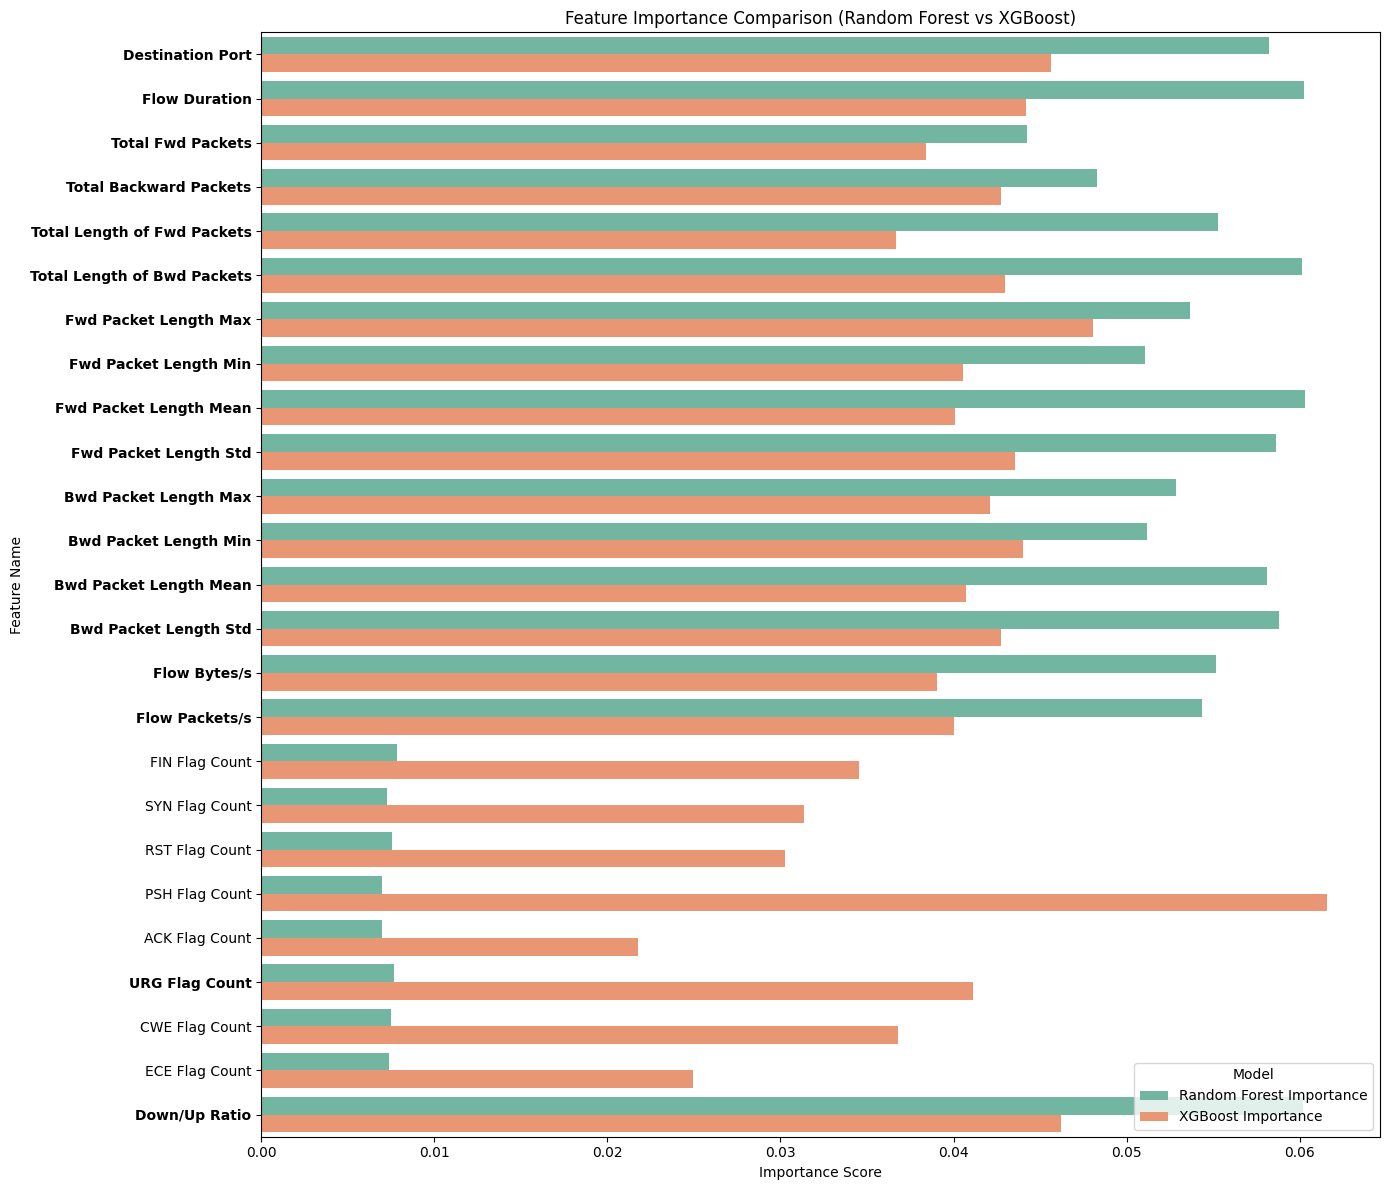

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get importances for all features
rf_selected_importances = [rf_importances[list(X.columns).index(feature)] for feature in X.columns]
xgb_selected_importances = [xgb_importances[list(X.columns).index(feature)] for feature in X.columns]

# Create DataFrame for plotting
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Random Forest Importance': rf_selected_importances,
    'XGBoost Importance': xgb_selected_importances
})

# Add a column to indicate selected features
feature_importance_df['Selected'] = feature_importance_df['Feature'].isin(selected_features)

# Melt for Seaborn barplot
feature_importance_melted = feature_importance_df.melt(
    id_vars=['Feature', 'Selected'],
    var_name='Model',
    value_name='Importance'
)

# Plotting
plt.figure(figsize=(14, 12))
sns.barplot(
    data=feature_importance_melted,
    x='Importance',
    y='Feature',
    hue='Model',
    palette='Set2',
    dodge=True
)

# Highlight selected features (optional tweak with bold labels)
for idx, row in feature_importance_df.iterrows():
    if row['Selected']:
        plt.gca().get_yticklabels()[idx].set_weight('bold')

plt.title('Feature Importance Comparison (Random Forest vs XGBoost)')
plt.xlabel('Importance Score')
plt.ylabel('Feature Name')
plt.legend(title='Model')
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np

# Load live data (captured without labels)
live_data_path = "/content/drive/My Drive/dataset/network_flow_features.csv"
live_data = pd.read_csv(live_data_path)

# Ensure columns are clean
live_data.columns = live_data.columns.astype(str).str.strip()

# Prepare the data (select the same features the model was trained on)
if hasattr(stacking_model, "feature_names_in_"):
    missing_cols = set(stacking_model.feature_names_in_) - set(live_data.columns)

    # Add any missing columns with default value (0)
    for col in missing_cols:
        live_data[col] = 0

    # Ensure correct column order
    live_data = live_data[stacking_model.feature_names_in_]

# Make predictions
predictions = stacking_model.predict(live_data)

# Map numerical predictions to human-readable labels
label_mapping = {0: "Normal", 1: "Malicious"}
predicted_labels = np.array([label_mapping[p] for p in predictions])

# Create a DataFrame for easy viewing
results_df = pd.DataFrame({
    "Predicted Label": predicted_labels
})


# Add a numbering column to the DataFrame
results_df['Row Number'] = range(1, len(results_df) + 1)

# Print all rows with numbering
print(results_df[['Row Number'] + [col for col in results_df.columns if col != 'Row Number']].to_string(index=False))





print("Prediction completed.")

 Row Number Predicted Label
          1          Normal
          2          Normal
          3          Normal
          4          Normal
          5          Normal
          6          Normal
          7          Normal
          8          Normal
          9          Normal
         10          Normal
         11          Normal
         12          Normal
         13          Normal
         14          Normal
         15          Normal
         16          Normal
         17          Normal
         18          Normal
         19          Normal
         20          Normal
         21          Normal
         22          Normal
         23          Normal
         24          Normal
         25          Normal
         26          Normal
         27          Normal
         28          Normal
         29          Normal
         30          Normal
         31          Normal
         32          Normal
         33          Normal
         34          Normal
         35         